本程序部分代码参考助教示例tutorial_2

In [11]:
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.autograd import Variable
import copy
from sklearn.metrics import accuracy_score,f1_score,roc_curve,precision_recall_curve,average_precision_score,auc
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix,matthews_corrcoef,roc_auc_score
import matplotlib.pyplot as plt
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch.utils.data.dataset as Dataset
import torch.utils.data.dataloader as DataLoader
from  torch.utils.model_zoo import load_url as load_state_dict_from_url
from PIL import Image

In [13]:
#本节参考pytorch官网https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
    #SE模块
    def se_resnet_bottleneck(l, ch_out, stride):
        shortcut = l
        l = Conv2D('conv1', l, ch_out, 1, activation=BNReLU)
        l = Conv2D('conv2', l, ch_out, 3, strides=stride, activation=BNReLU)
        l = Conv2D('conv3', l, ch_out * 4, 1, activation=get_bn(zero_init=True))

        squeeze = GlobalAvgPooling('gap', l)
        squeeze = FullyConnected('fc1', squeeze, ch_out // 4, activation=tf.nn.relu)
        squeeze = FullyConnected('fc2', squeeze, ch_out * 4, activation=tf.nn.sigmoid)
        data_format = get_arg_scope()['Conv2D']['data_format']
        ch_ax = 1 if data_format in ['NCHW', 'channels_first'] else 3
        shape = [-1, 1, 1, 1]
        shape[ch_ax] = ch_out * 4
        l = l * tf.reshape(squeeze, shape)
        out = l + resnet_shortcut(shortcut, ch_out * 4, stride, activation=get_bn(zero_init=False))
        return tf.nn.relu(out)
    
    def GlobalAvgPooling(x, data_format='channels_last'):
        assert x.shape.ndims == 4
        data_format = get_data_format(data_format)
        axis = [1, 2] if data_format == 'channels_last' else [2, 3]
        return tf.reduce_mean(x, axis, name='output')



class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, inplanes, planes, pretrained, progress, **kwargs):
    model = ResNet(inplanes, planes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [14]:
model = resnet34().cuda(1) #实例化卷积层
loss = nn.CrossEntropyLoss() #损失函数选择，交叉熵函数
optimizer = optim.SGD(model.parameters(),lr = 0.1,momentum=0.9,weight_decay=0.00004)
#动态调整学习率
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'max',factor=0.5, patience=4, verbose=True)
num_epochs = 80

In [15]:
losses = [] 
acces = []
eval_losses = []
eval_acces = []
Tr_loss=[]
Tr_acc=[]
Tr_echo=[]
Te_loss=[]
Te_acc=[]

for echo in range(num_epochs):
    #scheduler.step()
    train_loss = 0   #定义训练损失
    train_acc = 0    #定义训练准确度
    model.train()    #将网络转化为训练模式
    for i,(X,label) in enumerate(train_loader):     #使用枚举函数遍历train_loader
        #X = X.view(-1,784)       #X:[64,1,28,28] -> [64,784]将X向量展平
        label=label.transpose(0,1)
        label=label[:1]
        label=torch.squeeze(label)
        X = Variable(X).cuda(1)          #包装tensor用于自动求梯度
        label = Variable(label).cuda(1)
        label=label.long()
        out = model(X)           #正向传播
        lossvalue = loss(out,label)         #求损失值
        optimizer.zero_grad()       #优化器梯度归零
        lossvalue.backward()    #反向转播，刷新梯度值
        optimizer.step()        #优化器运行一步，注意optimizer搜集的是model的参数
        
        #计算损失
        train_loss += float(lossvalue)      
        #计算精确度
        _,pred = out.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    print("echo:"+' ' +str(echo))
    print("lose:" + ' ' + str(train_loss / len(train_loader)))
    print("train_acc:" + ' '+str(train_acc / len(train_loader)))
    Tr_echo.append(echo)
    Tr_loss.append(train_loss / len(train_loader))
    Tr_acc.append(train_acc / len(train_loader))
    
    #测试
    eval_loss = 0
    eval_acc = 0
    label_all = None
    pred_all = None
    pred_pro_all = None
    model.eval() #模型转化为评估模式
    for X,label in my_test_loader:
        #X = X.view(-1,784)
        label=label.transpose(0,1)
        label=label[:1]
        label=torch.squeeze(label)
        X = Variable(X).cuda(1)
        label = Variable(label).cuda(1)
        with torch.no_grad():
            testout = model(X)
        label=label.long()
        testloss = loss(testout,label)
        eval_loss += float(testloss)

        _, pred = testout.max(1)
        if label_all is None:
            label_all = label
        else:
            label_all = torch.cat([label_all,label])

        if pred_all is None:
            pred_all = torch.cat([pred])
        else:
            pred_all = torch.cat([pred_all,pred])

        if pred_pro_all is None:
            pred_pro_all = torch.cat([F.sigmoid(testout)])
        else:
            pred_pro_all = torch.cat([pred_pro_all,F.sigmoid(testout)])
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        eval_acc += acc
    print("loss:" + ' '+str(eval_loss / len(my_test_loader)))
    print("test_acc:" + ' '+str(eval_acc / len(my_test_loader)))
    Te_loss.append(eval_loss / len(my_test_loader))
    Te_acc.append(eval_acc / len(my_test_loader))  
    
    scheduler.step(eval_acc)
    

echo: 0
lose: 1.4022422502641483
train_acc: 0.5244108512970406


/home/srt/anaconda3/envs/ai_project_3/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.8898713583019888
test_acc: 0.6690741583257507
echo: 1
lose: 0.7483521802041232
train_acc: 0.7137319601753745
loss: 0.6466092443105521
test_acc: 0.7567675159235668
echo: 2
lose: 0.6525633270325868
train_acc: 0.7500570880526124
loss: 0.6168156477865899
test_acc: 0.7615445859872612
echo: 3
lose: 0.5896778762188104
train_acc: 0.7783670533430763
loss: 0.5981684082015685
test_acc: 0.7842356687898089
echo: 4
lose: 0.5457963678614258
train_acc: 0.7952137376689806
loss: 0.5546230743075632
test_acc: 0.7931926751592356
echo: 5
lose: 0.5016464745373372
train_acc: 0.8124942911947387
loss: 1.1142716696307917
test_acc: 0.6483735213830756
echo: 6
lose: 0.4679109060474674
train_acc: 0.8256473785166241
loss: 0.6755712187024439
test_acc: 0.7509952229299363
echo: 7
lose: 0.44859174677096975
train_acc: 0.83284047314578
loss: 0.4378608317962687
test_acc: 0.8401671974522293
echo: 8
lose: 0.42604196839549047
train_acc: 0.8418718030690537
loss: 0.4346909301984272
test_acc: 0.8401671974522293
echo: 9
lo

loss: 0.3717898213127361
test_acc: 0.9078423566878981
echo: 71
lose: 0.04679991660938572
train_acc: 0.9836556905370843
loss: 0.38148503993945765
test_acc: 0.9052547770700637
echo: 72
lose: 0.0474006547151929
train_acc: 0.9834958439897699
loss: 0.3861197904905358
test_acc: 0.9040605095541401
Epoch    72: reducing learning rate of group 0 to 3.1250e-03.
echo: 73
lose: 0.038652702310906194
train_acc: 0.9874920076726342
loss: 0.37951820009506854
test_acc: 0.910828025477707
echo: 74
lose: 0.03841592569042312
train_acc: 0.987531969309463
loss: 0.39145273423032945
test_acc: 0.9084394904458599
echo: 75
lose: 0.03706099655922226
train_acc: 0.9881313938618926
loss: 0.3837708969404743
test_acc: 0.9086385350318471
echo: 76
lose: 0.033536652412713336
train_acc: 0.9891075995615638
loss: 0.3950740947736339
test_acc: 0.9074442675159236
echo: 77
lose: 0.03216622654429596
train_acc: 0.9897298593350383
loss: 0.39011017575557494
test_acc: 0.9096337579617835
echo: 78
lose: 0.03183256092902911
train_acc: 0.

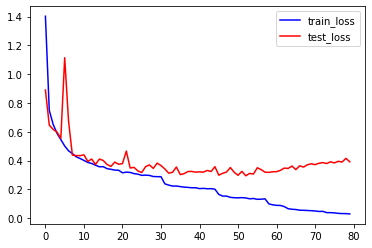

In [16]:
#绘图
plt.plot(Tr_echo, Tr_loss, label="train_loss",color='b')
plt.plot(Tr_echo, Te_loss, label="test_loss",color='r')
plt.legend()
plt.show()

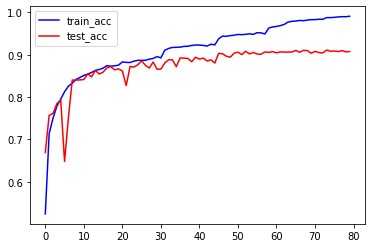

In [17]:
plt.plot(Tr_echo, Tr_acc, label="train_acc",color='b')
plt.plot(Tr_echo, Te_acc, label="test_acc",color='r')
plt.legend()
plt.show()

In [18]:

label_all = None
pred_all = None
pred_pro_all = None
model.eval() #模型转化为评估模式
for X,label in test_loader:
    X = Variable(X).cuda(1)
    with torch.no_grad():
        testout = model(X)

    _, pred = testout.max(1)
    if label_all is None:
        label_all = label
    else:
        label_all = torch.cat([label_all,label])

    if pred_all is None:
        pred_all = torch.cat([pred])
    else:
        pred_all = torch.cat([pred_all,pred])

    if pred_pro_all is None:
        pred_pro_all = torch.cat([F.sigmoid(testout)])
    else:
        pred_pro_all = torch.cat([pred_pro_all,F.sigmoid(testout)])

y_pred = pred_all.cpu().detach().numpy()
print(y_pred)
y_pred = pd.DataFrame(y_pred) 
y_ind=np.arange(0,5000,1)
y_ind = pd.DataFrame(y_ind)
predictions = pd.concat([y_ind,y_pred], axis =1) 
predictions.columns = ['image_id','label'] 
predictions.to_csv('submit.csv', index = False)
y_pred_pro = pred_pro_all.cpu().detach().numpy()

[7 6 3 ... 3 7 3]
